In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)


# Lecture 04 - Hypothesis Testing 💭

## DSC 80, Fall 2022

## Today, in DSC 80...

- The theory of hypothesis testing.
- Total variation distance.
- Another example – penguin bill lengths 🐧.

Throughout this lecture, we will look at how to "speed up" our hypothesis tests by avoiding `for`-loops entirely.

## Announcements 📣

- 

## Hypothesis testing

### Hypothesis testing

- There are many competing ways of viewing how the world works.
    - That is, competing **models** for how the data were **generated**.
- How do we decide which models are unlikely to be true, and which are reasonable?
- **Hypothesis testing**.

### Example: coin flipping

Below, we create a DataFrame of coin flips.

In [5]:
np.random.seed(42)

flips = pd.DataFrame(np.random.choice(['H', 'T'], p=[0.55, 0.45], size=(114, 1)), columns=['result'])
flips.head()

,result
0,H
1,T
2,T
3,T
4,H


In [6]:
flips.shape

(114, 1)

In [8]:
flips['result'].value_counts(normalize=True)

H    0.596491
T    0.403509
Name: result, dtype: float64

There were 114 flips, 68 of which were heads (or ~59%).

### Example: coin flips

- There are two competing views:
    - the coin is fair
    - the coin is unfair (biased towards heads)
- "The coin is fair" is making a probabilistic claim that we can test.
- How likely is it that this data could have been generated from a fair coin?

### Null hypothesis

- Recall, a **null hypothesis** is an initial or default belief as to how data were generated.
    - The null hypothesis must be a **probability model**, i.e. something that we can simulate under.

- Often, but not always, the null hypothesis states there is no association or difference between variables or subpopulations, and that any observed differences were due to random chance. 
- Examples:
    * The coin was fair.
    * The music preferences of Americans and Canadians are the same.
    * The median number of Instagram followers of DSC majors is equal to the median number of Instagram followers of all students at UCSD.

### Alternative hypothesis

- An **alternative hypothesis** is a different viewpoint as to how data were generated.
- The alternative hypothesis typically states that the difference between variables or subpopulations exists and is not due to random chance.
- Examples:
    - The coin is biased towards heads.
    - The coin is biased.
    - The music preferences of Americans and Canadians are different.
    - The median number of Instagram followers of DSC majors is greater than the median number of Instagram followers of all students at UCSD.

### Test statistics

- A **test statistic** is a number that we compute in each repetition of an experiment, to help us make a decision.
- We'd like to choose a test statistic such that large values of the test statistic correspond to one hypothesis, and small values correspond to the other. **In other words, we'll try to avoid "two-tailed tests".**
- For example, suppose we flipped a coin $N$ times and we saw $N_H$ heads.

For the alternative hypothesis "the coin was biased towards heads", we could use:
* $N_H$ (number of heads).
* $\frac{N_H}{N}$ (proportion of heads).
* $N_H - \frac{N}{2}$ (difference from expected number of heads).

**If these test statistics are large, it means there were many heads. If they are small, it means there were few heads.**

For the alternative hypothesis "the coin was biased", we could use:
- $|N_H - \frac{N}{2}|$ (absolute difference from expected number of heads).

**If this test statistic is large, it means that there were many more heads than expected, or many fewer heads than expected. If this test statistic is small, it means that the number of heads was close to expected.**

- For instance, suppose we flip 100 coins, and I tell you the absolute difference from the expected number of heads is 20.
- Then, either we flipped 70 heads or 30 heads. 
- If our alternative hypothesis is that the coin was biased, then it doesn't matter in which direction it was biased, and this test statistic works.
- But our alternative hypothesis is that the coin was biased towards heads, then this is not helpful, because we don't know whether or not there were 70 heads (evidence for the alternative) or 30 heads (not evidence for the alternative).  

### Generating the null distribution

After choosing a test statistic, we need to compute the **distribution of the test statistic, under the assumption that the null hypothesis is true** ("under the null").
- In DSC 10 and 80, we do this through simulation, which means our null distributions are **empirical** and our calculations are approximate.
- In other courses, you may do this by-hand (e.g. in a coin flipping example, you could use the binomial distribution).

### Example: coin flipping

Recall our dataframe of 100 coin flips:

In [11]:
flips

,result
0,H
1,T
2,T
3,T
4,H
...,...
109,H
110,H
111,H
112,T


In [12]:
flips.value_counts()

result
H         68
T         46
dtype: int64

Is the coin fair?

### Setup

- **Null hypothesis:** The coin was fair, and any deviations were due to random chance.
- **Alternative hypothesis:** The coin was biased towards heads.
- **Test statistic:** Number of heads ($N_H$).

Steps:
1. Compute the **observed value** of the test statistic, i.e. the observed number of heads. (We already know this to be 68.)
2. Calculate the probability of seeing a test statistic this extreme under the null.
    - Can do this with *math* (MATH 183)
    - Or, can estimate probabilities via simulation (flip a bunch of fair coins)
3. Use the resulting distribution to calculate the (approximate) probability of seeing 68 or more heads in 114 coin flips, under the assumption the coin was fair.

### Simulation

In [ ]:
# 100,000 times, we want to flip a coin 114 times
results = []

for _ in range(100000):
    simulation = np.random.choice(['H', 'T'], size=114)
    sim_heads = (simulation == 'H').sum()  # Test statistic
    results.append(sim_heads)

Each entry in `results` is the number of heads in 114 simulated coin flips.

In [ ]:
results[:10]

### Plotting the empirical distribution of the test statistic

In [ ]:
pd.Series(results).plot(kind='hist', 
                        density=True,
                        bins=np.arange(35, 76, 1),
                        ec='w',
                        title='Number of Heads in 114 Flips of a Fair Coin');
obs = (flips['result'] == 'H').sum()
plt.axvline(x=obs, color='red', linewidth=2);

**Question:** Do you think the coin was fair?

In [ ]:
(np.array(results) >= obs).mean()

- Under the assumption the coin is fair, the probability of seeing 68 or more heads is ~2.5%.
    - This is called a **p-value**.
- So either:
    - The coin is fair and we saw a really rare event, or
    - The coin is not fair.
- We need a **cutoff** to determine whether to reject the null hypothesis, given this probability.

### P-values and cutoffs

- The **p-value**, or **observed significance level**, is the probability, under the null hypothesis, that the test statistic is equal to the value that was observed in the data or is even further in the direction of the alternative.
- If the p-value is below a pre-determined **cutoff**, or **significance level**, we say that our observation is inconsistent with the null hypothesis and we **reject the null**.
    - 0.05 (significant) and 0.01 (highly significant) are common cutoffs.
    - If the p-value is above the cutoff, we **fail to reject the null**.
- Note that the cutoff is an **error probability**.
    - If your cutoff is 0.05, then 5% of the time, you will incorrectly reject the null hypothesis.

### ⚠️ We can't "prove" the null!

- Note that we are very careful in saying that we either **reject the null** or **fail to reject the null**.
- If our observed data is close to what we'd expect under the null, we fail to reject the null, but we still don't know whether or not it is true!
- The null hypothesis is very, very specific, e.g. the coin was exactly fair.
- Example:
    - Suppose there is a coin that is truly biased towards heads, with probability 0.55.
    - We flip it 10 times and see 5 heads and 5 tails.
    - If we conduct a hypothesis test where the null is that the coin is fair, we will fail to reject the null.
    - But the null isn't true.

### Fun fact

- One researcher found that coin flips aren't 50/50, but rather are closer to 51/49, biased towards whichever side started facing up.
- [Read this](https://www.smithsonianmag.com/science-nature/gamblers-take-note-the-odds-in-a-coin-flip-arent-quite-5050-145465423) for more details.

## Efficiency

### Speeding things up 🏃

- To estimate the null distribution, we flipped a coin 114 times, 100,000 times. This involved 100,000 iterations of a `for`-loop.
- We can avoid a `for`-loop entirely by using the `size` argument in `np.random.choice` (and in other `np` random functions).
    - Idea: Generate a 2D array of coin flips with 114 columns and 100,000 rows. Each row corresponds to one run of our previous `for`-loop.
    - This will work if each trial (e.g. coin flip) is independent.
    - We can then sum each row of the resulting array to get our distribution. However, this requires the entries in the array to be numbers – let's replace `'H'` with 1 and `'T'` with 0. 

In [3]:
np.random.seed(42)

flips = pd.DataFrame(np.random.choice(['H', 'T'], p=[0.55, 0.45], size=(114, 1)), columns=['result'])
flips.head()

,result
0,H
1,T
2,T
3,T
4,H


In [4]:
flips.head()

,result
0,H
1,T
2,T
3,T
4,H


In [5]:
flips_fast = flips.replace({'H': 1, 'T': 0})
flips_fast.head()

,result
0,1
1,0
2,0
3,0
4,1


The following function takes in a value of `N` and flips a fair coin `N * 114` times.

In [6]:
def flip_114(N):
    return np.random.choice([1, 0], size=(N, 114))

In [7]:
flip_114(50)

array([[1, 1, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 0, 1]])

In [8]:
flip_114(50).shape

(50, 114)

### Timing the faster simulation

In [9]:
%%time

# Flips a fair coin 100,000 * 114 times
simulations = pd.DataFrame(flip_114(100000))

# Compute test statistics
# Note that axis=1 will take the sum of each row of 114, which is what we want
results_fast = simulations.sum(axis=1)

CPU times: user 96.6 ms, sys: 29.2 ms, total: 126 ms
Wall time: 133 ms


NameError: name 'plt' is not defined

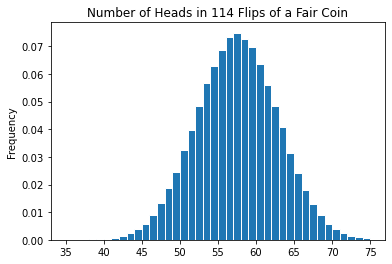

In [10]:
pd.Series(results_fast).plot(kind='hist', 
                        density=True,
                        bins=np.arange(35, 76, 1),
                        ec='w',
                        title='Number of Heads in 114 Flips of a Fair Coin');
plt.axvline(x=obs, color='red', linewidth=2);

## Total variation distance

### Ethnic distribution of California vs. UCSD

- The DataFrame below contains the ethnic breakdown of the state as a whole ([source](https://www.ppic.org/publication/californias-population/)) and UCSD as of 2016 ([source](https://ir.ucsd.edu/_files/stats-data/enrollment/ugethnic.pdf)).

In [ ]:
eth = pd.DataFrame([['Asian', 0.15, 0.51],
                    ['Black', 0.05, 0.02],
                    ['Latino', 0.39, 0.16],
                    ['White', 0.35, 0.2],
                    ['Other', 0.06, 0.11]],
                   columns=['Ethnicity', 'California', 'UCSD']).set_index('Ethnicity')

eth

- We want to decide whether UCSD students were drawn at random from the state of California.
- The two **categorical distributions** above are clearly different. But how different are they?

### Is the difference between the two distributions significant?

Let's establish our hypotheses.
- **Null hypothesis:** UCSD students **were** selected at random from the population of California residents.
- **Alternative hypothesis:** UCSD students **were not** selected at random from the population of California residents.
- Our **observation** is the ethnic distribution of UCSD students.
- We need a way of quantifying **how different** two categorical distributions are.

In [ ]:
eth.plot(kind='barh', title='Ethnic Distribution of California and UCSD');

### Total variation distance

The total variation distance (TVD) is a test statistic that describes the **distance between two categorical distributions**.

If $A = [a_1, a_2, ..., a_k]$ and $B = [b_1, b_2, ..., b_k]$ are both categorical distributions, then the TVD between $A$ and $B$ is

$$\text{TVD}(A, B) = \frac{1}{2} \sum_{i = 1}^k |a_i - b_i|$$

In [ ]:
def total_variation_distance(dist1, dist2):
    '''Given two categorical distributions, 
    both sorted with same categories, calculates the TVD'''
    return np.sum(np.abs(dist1 - dist2)) / 2

Below, we can compute the TVD between California's ethnic distribution and UCSD's ethnic distribution.

In [ ]:
observed_tvd = total_variation_distance(eth['California'], eth['UCSD'])
observed_tvd

The issue is we don't know whether this is a large value or a small value.

### The plan

To conduct our hypothesis test:

- Repeatedly generate samples of size 30,000 (number of UCSD students) from the ethnic distribution of all of California.
- Each time, compute the TVD between the simulated distribution and California's distribution.
- **This will generate an empirical distribution of TVDs, under the null.**
- Finally, determine whether the observed TVD is consistent with the empirical distribution of TVDs.

### Generating one random sample

To sample from a categorical distribution, we use `np.random.multinomial`.

In [ ]:
np.random.multinomial(10, [0.5, 0.5])

In [ ]:
eth['California']

In [ ]:
N_STUDENTS = 30_000

In [ ]:
np.random.multinomial(N_STUDENTS, eth['California'])

In [ ]:
np.random.multinomial(N_STUDENTS, eth['California']) / N_STUDENTS

Now we need to repeat the process of creating samples, many, many times.

### Simulation

In [ ]:
num_reps = 10000
tvds = []

for i in np.arange(num_reps):
    random_sample = np.random.multinomial(N_STUDENTS, eth['California']) / N_STUDENTS
    new_tvd = total_variation_distance(eth['California'], random_sample)
    tvds.append(new_tvd)

In [ ]:
pd.Series(tvds).plot(kind='hist', 
                     density=True,
                     ec='w',
                     title='Simulated TVDs');
# plt.axvline(x=observed_tvd, color='red', linewidth=2);

- The chance that the observed TVD came from the distribution of TVDs under the null is essentially 0.
- This matches our intuition from the start – the two distributions looked very different to begin with. But now we're quite sure the difference can't be explained solely due to chance.

### Speeding things up 🏃

Again, we can get rid of the loop by using the `size` argument!

In [ ]:
eth_draws = np.random.multinomial(N_STUDENTS, eth['California'], size=num_reps) / N_STUDENTS
eth_draws

- Notice that each row of `eth_draws` sums to 1, because each row is a simulated categorical distribution.
- `eth_draws` has `num_reps` (10,000) rows.

In [ ]:
eth_draws.shape

Our previous `total_variation_distance` function won't work with our 2D array `eth_draws`.

In [ ]:
tvds_fast = np.sum(np.abs(eth_draws - eth['California'].to_numpy()), axis=1) / 2
tvds_fast

In [ ]:
pd.Series(tvds_fast).plot(kind='hist', 
                     density=True,
                     ec='w',
                     title='Simulated TVDs (without using a loop)');
# plt.axvline(x=observed_tvd, color='red', linewidth=2);

### Summary of the method

To assess whether an "observed sample" was drawn randomly from a known categorical distribution:
* Use the TVD as the test statistic because it measures the distance between two categorical distributions.
* Sample at random from the population. Compute the TVD between each random sample and the known distribution to get an idea for what reasonable deviations from the eligible pool look like. Repeat this process many, many times.
* Compare:
    - the empirical distribution of TVDs, with
    - the observed TVD from the sample.

### Aside

- It was probably obvious that the difference is significant even before running a hypothesis test.
- Why? There are 30,000 students. Such a difference in proportion is unlikely to be due to random chance (something more systematic at play).
- But what if `N_STUDENTS = 3_000` or `N_STUDENTS = 300`?

### Discussion Question

- At what value of `N_STUDENTS` do you think our hypothesis test would fail to reject the null?

In [ ]:
N_STUDENTS = 3_000

In [ ]:
eth_draws = np.random.multinomial(N_STUDENTS, eth['California'], size=num_reps) / N_STUDENTS
eth_draws

In [ ]:
tvds_fast = np.sum(np.abs(eth_draws - eth['California'].to_numpy()), axis=1) / 2
tvds_fast

In [ ]:
pd.Series(tvds_fast).plot(kind='hist', 
                     density=True,
                     ec='w',
                     title='Simulated TVDs (without using a loop)');
plt.axvline(x=observed_tvd, color='red', linewidth=2);

## Another example

<center><img src='imgs/lter_penguins.png' width=60%></center>

([source](https://allisonhorst.github.io/palmerpenguins/articles/intro.html))

### Aside: loading data from `seaborn`

- `seaborn` is a visualization library for Python that works well with `pandas`.
- `seaborn` has a `load_dataset` function that reads in datasets from [this repo](https://github.com/mwaskom/seaborn-data).

In [14]:
import seaborn as sns

In [15]:
penguins = sns.load_dataset('penguins').dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


<center><img src='imgs/culmen_depth.png' width=60%></center>

### Average bill length by island

We will learn about the `groupby` method next week.

In [16]:
penguins.groupby('island')['bill_length_mm'].agg(['mean', 'count'])

,mean,count
island,,
Biscoe,45.248466,163
Dream,44.221951,123
Torgersen,39.038298,47


It appears that penguins on Torgersen Island have shorter bills on average than penguins on other islands. Could this have happened due to random chance?

### Setup

- **Null hypothesis:** Island and bill length **are not** related – the low average bill length of Torgersen Island penguins is due to chance alone.
    - In other words, if we picked 47 penguins randomly from the population of 333 penguins, it is reasonable to see an average this low.
- **Alternative hypothesis:** Island and bill length **are** related – the low average bill length of Torgersen Island penguins is not due to chance alone.

### The plan

- The null hypothesis states that the 47 bill lengths of Torgersen Island penguins were drawn uniformly at random from the 333 bill lengths in the population.
- That is, if we repeatedly sampled groups of 47 penguins from the population and computed their average bill length, it would not be uncommon to see an average bill length this low.
- **Plan:** Repeatedly sample (without replacement) 47 penguins from the population and **compute their average bill length**, and see where the Torgersen Island average bill length lies in this distribution.
    - Average bill length is our **test statistic**.
    - This is not a test statistic we've used in this lecture yet (and this is what separates this example from previous examples).

### Simulation

In [17]:
num_reps = 1_000

In [18]:
averages = []

for i in np.arange(num_reps):
    random_sample = penguins.sample(47)
    new_average = random_sample['bill_length_mm'].mean()
    averages.append(new_average)

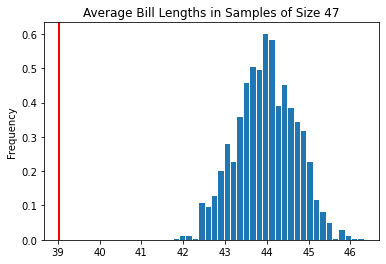

In [19]:
pd.Series(averages).plot(kind='hist', 
                         density=True,
                         bins=30,
                         ec='w',
                         title='Average Bill Lengths in Samples of Size 47');

observed_average = penguins.groupby('island').mean().loc['Torgersen', 'bill_length_mm']
plt.axvline(x=observed_average, color='red', linewidth=2);

It doesn't look like the average bill length of Torgersen Island penguins came from the null distribution of average bill lengths.

### Speeding things up 🏃

Again (again), we can get rid of the loop by using the `size` argument!

In [20]:
np.random.choice(penguins['bill_length_mm'], size=(5, 47))

array([[45.2, 42.6, 58. , 49.8, 47.4, 43.2, 50.7, 48.5, 40.8, 52.2, 36.5,
        47. , 45.8, 59.6, 39.5, 45.7, 42. , 46. , 46.4, 37.5, 41.5, 38.2,
        45.2, 51.5, 43.4, 49.1, 49.5, 45.6, 33.1, 51.5, 47.8, 45.5, 40.6,
        52.2, 43.4, 41.8, 34.6, 50.8, 42.2, 53.5, 39.6, 39. , 43.2, 47.6,
        36. , 50.5, 51.1],
       [39.7, 42.5, 44.9, 40.5, 49.6, 36.6, 49.3, 45.7, 47.5, 46.8, 43.2,
        42.5, 35. , 39. , 41.1, 39.8, 45.2, 45.2, 40.3, 51.5, 40.9, 48.5,
        47.3, 33.5, 49.1, 37.2, 48.7, 41.1, 43.2, 49.8, 41.1, 46.9, 40.2,
        45. , 39.5, 41.1, 45.4, 49.3, 40.6, 35.1, 35. , 36.4, 39.7, 46.4,
        40.2, 37.6, 45.2],
       [37.6, 42.4, 51.1, 45.8, 50.8, 48.1, 53.5, 44.9, 37.7, 39.6, 35.7,
        40.9, 49.2, 46.5, 40.9, 51.3, 41.3, 37.9, 49.5, 35.7, 49.5, 35.1,
        45.7, 43.2, 35.9, 45.8, 44.4, 41.1, 50.9, 45.1, 45.5, 50. , 46.2,
        36.2, 45.9, 50.4, 35.7, 40.6, 38.6, 36.2, 33.5, 51.3, 59.6, 38.8,
        45.4, 43.6, 50. ],
       [53.5, 37.8, 35.6, 35. ,

In [21]:
averages_fast = np.random.choice(penguins['bill_length_mm'], size=(num_reps, 47)).mean(axis=1)
averages_fast

array([43.91489362, 44.31914894, 45.57659574, 42.80851064, 45.05744681,
       43.81702128, 44.03617021, 43.98510638, 43.62553191, 43.22553191,
       43.9212766 , 43.3212766 , 44.15744681, 44.        , 44.33617021,
       44.78510638, 43.9787234 , 45.05319149, 42.22765957, 44.03191489,
       43.04468085, 44.62765957, 43.93829787, 43.76595745, 44.40851064,
       42.15319149, 41.96382979, 45.05531915, 43.83191489, 43.26382979,
       42.25106383, 44.41489362, 41.71276596, 43.59574468, 43.09148936,
       43.86170213, 44.58085106, 45.01489362, 43.09574468, 42.08297872,
       44.92978723, 43.51702128, 43.78297872, 43.70212766, 43.13191489,
       44.06808511, 43.66170213, 44.15531915, 43.15957447, 43.0212766 ,
       44.21914894, 44.61914894, 43.96808511, 44.02340426, 42.48085106,
       44.68297872, 44.99148936, 43.96595745, 43.84468085, 43.7212766 ,
       43.76170213, 43.36382979, 43.61914894, 43.49361702, 44.59787234,
       43.85319149, 44.52553191, 44.49148936, 45.49361702, 43.44

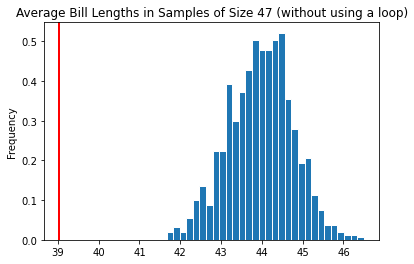

In [22]:
pd.Series(averages_fast).plot(kind='hist', 
                              density=True,
                              bins=30,
                              ec='w',
                              title='Average Bill Lengths in Samples of Size 47 (without using a loop)');

observed_average = penguins.groupby('island').mean().loc['Torgersen', 'bill_length_mm']
plt.axvline(x=observed_average, color='red', linewidth=2);

We get the same result, but much quicker!

## Summary

### The hypothesis testing "recipe"

Faced with a question about the data raised by an observation...
1. Carefully pose the question as a testable "yes or no" hypothesis.
2. Decide on a **test statistic** that helps differentiate between instances that would affirm or reject the hypothesis.
3. Create a probability model for the data generating process that reflects the "known behavior" of the process.
4. Simulate the data generating process using this probability model (the "**null hypothesis**").
5. Assess if the observation is consistent with the simulations by computing a **p-value**.

We looked at three key examples:
- Coin flipping.
- Comparing categorical distributions.
- Comparing a subgroup statistic to a population parameter.

## Next time in DSC 80...

- Guest lecture by Eric Colson of Netflix/Stitchfix.